In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvi

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, GaussNoise
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

Classes: ['non shop lifters', 'shop lifters']
{'non shop lifters': 531, 'shop lifters': 324}


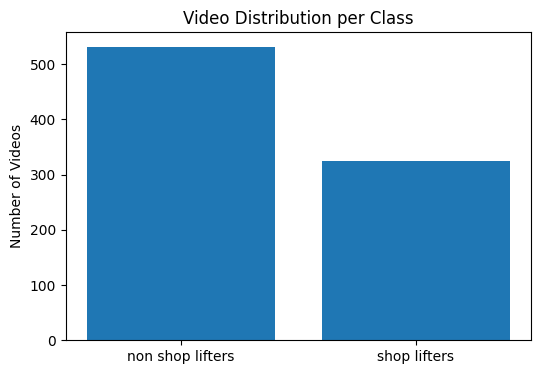

In [3]:
data_root = "/kaggle/input/shop-dataset/Shop DataSet"

classes = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])
print("Classes:", classes)

# Class distribution
def count_videos_per_class(root):
    counter = {}
    for cls in classes:
        cls_path = os.path.join(root, cls)
        vids = [f for f in os.listdir(cls_path) if f.lower().endswith(('.mp4', '.avi'))]
        counter[cls] = len(vids)
    return counter

# Visualization
def visualize_class_dist(counter):
    plt.figure(figsize=(6,4))
    plt.bar(counter.keys(), counter.values())
    plt.ylabel('Number of Videos')
    plt.title('Video Distribution per Class')
    plt.show()

count = count_videos_per_class(data_root)
print(count)
visualize_class_dist(count)

In [4]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=16, size=(224, 224)):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.size = size

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, self.size)
            frames.append(frame)
        cap.release()

        total = len(frames)
        if total >= self.num_frames:
            indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        else:
            frames += [frames[-1]] * (self.num_frames - total)

        frames = np.array(frames, dtype=np.float32) / 255.0
        frames = torch.tensor(frames).permute(0, 3, 1, 2)  # (T, C, H, W)
        return frames, label


In [9]:
data, labels = [], []
for label, cls in enumerate(classes):
    folder = os.path.join(data_root, cls)
    for file in os.listdir(folder):
        if file.lower().endswith('.mp4'):
            data.append(os.path.join(folder, file))
            labels.append(label)

num_frames = 16
img_size = (224, 224)
batch_size = 8

# Split
train_paths, test_paths, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, y_val, y_test = train_test_split(test_paths, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Datasets
train_dataset = VideoDataset(train_paths, y_train, num_frames, img_size)
val_dataset = VideoDataset(val_paths, y_val, num_frames, img_size)
test_dataset = VideoDataset(test_paths, y_test, num_frames, img_size)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
f1_metric = BinaryF1Score().to('cuda')  

class EfficientNetB0_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=1):
        super().__init__()
        
        # Pretrained EfficientNetB0 backbone
        backbone = efficientnet_b0(pretrained=True)
        backbone.classifier = nn.Identity()  # remove classification head
        self.backbone = backbone
        
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Sequence modeling
        self.lstm = nn.LSTM(
            input_size=1280,  # EfficientNetB0 output feature size
            hidden_size=hidden_size,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x shape: (batch, time, C, H, W)
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)              # merge batch & time for CNN
        
        feats = self.backbone(x)                # (b*t, 1280)
        feats = feats.view(b, t, -1)             # (batch, time, 1280)
        
        _, (h_n, _) = self.lstm(feats)           # h_n: (1, batch, hidden_size)
        h_n = h_n.squeeze(0)
        
        out = self.dropout(h_n)
        out = self.fc(out)
        
        # Binary Classification
        return torch.sigmoid(out)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EfficientNetB0_LSTM().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
f1_metric = BinaryF1Score().to(device)

for epoch in range(5):
    model.train()
    total_loss, total_f1 = 0, 0
    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).int()
        total_loss += loss.item()
        total_f1 += f1_metric(preds, labels.int()).item()

    avg_loss = total_loss / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | F1: {avg_f1:.4f}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 136MB/s]
Epoch 1: 100%|██████████| 75/75 [04:35<00:00,  3.67s/it]


Epoch 1 | Loss: 0.6467 | F1: 0.2815


Epoch 2: 100%|██████████| 75/75 [04:40<00:00,  3.74s/it]


Epoch 2 | Loss: 0.4910 | F1: 0.5431


Epoch 3: 100%|██████████| 75/75 [04:42<00:00,  3.76s/it]


Epoch 3 | Loss: 0.3039 | F1: 0.8290


Epoch 4: 100%|██████████| 75/75 [04:49<00:00,  3.86s/it]


Epoch 4 | Loss: 0.1888 | F1: 0.9088


Epoch 5: 100%|██████████| 75/75 [04:45<00:00,  3.81s/it]

Epoch 5 | Loss: 0.1749 | F1: 0.9019


In [13]:
# Create test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Metrics
acc_metric = BinaryAccuracy().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

# Evaluation function
def evaluate(model, loader, name="Eval"):
    model.eval()
    total_loss, total_f1, total_acc, total_prec, total_rec = 0, 0, 0, 0, 0

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos).squeeze(1)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.5).int()

            total_loss += loss.item()
            total_f1 += f1_metric(preds, labels.int()).item()
            total_acc += acc_metric(preds, labels.int()).item()
            total_prec += precision_metric(preds, labels.int()).item()
            total_rec += recall_metric(preds, labels.int()).item()

    n = len(loader)
    print(f"{name} | Loss: {total_loss/n:.4f} | "
          f"F1: {total_f1/n:.4f} | Acc: {total_acc/n:.4f} | "
          f"Prec: {total_prec/n:.4f} | Rec: {total_rec/n:.4f}")

# Evaluate after training
print("\nValidation Results:")
evaluate(model, val_loader, "Validation")

print("\nTest Results:")
evaluate(model, test_loader, "Test")



Validation Results:
Validation | Loss: 0.0990 | F1: 0.9719 | Acc: 0.9766 | Prec: 0.9542 | Rec: 1.0000

Test Results:
Test | Loss: 0.1020 | F1: 0.9178 | Acc: 0.9779 | Prec: 0.9000 | Rec: 0.9412


In [22]:
def visualize_frames(vid='/kaggle/input/shop-dataset/Shop DataSet/shop lifters/shop_lifter_0.mp4'):
    # Load YOLO pretrained model
    yolo_model = YOLO('yolov8n.pt')  # Pretrained on COCO
    
    # Open input video
    cap = cv2.VideoCapture(vid)
    
    # Video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))
    
    frames_to_show = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
    
        # Run YOLO person detection (no labels)
        results = yolo_model.predict(frame, classes=[0], verbose=False)  # class 0 = person
    
        # Draw green boxes without labels
        for box in results[0].boxes.xyxy:  # xyxy format
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)  # Green box
    
        out.write(frame)
    
        # Store every 30th frame for display
        if frame_count % 30 == 0:
            frames_to_show.append(frame.copy())
    
        frame_count += 1
    
    cap.release()
    out.release()
    
    print("Video saved as 'output.mp4'")
    
    while len(frames_to_show) < 10:
        frames_to_show.append(np.zeros_like(frames_to_show[0]))
    
    # Display frames in 2x8 grid
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(frames_to_show[i], cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Video saved as 'output.mp4'


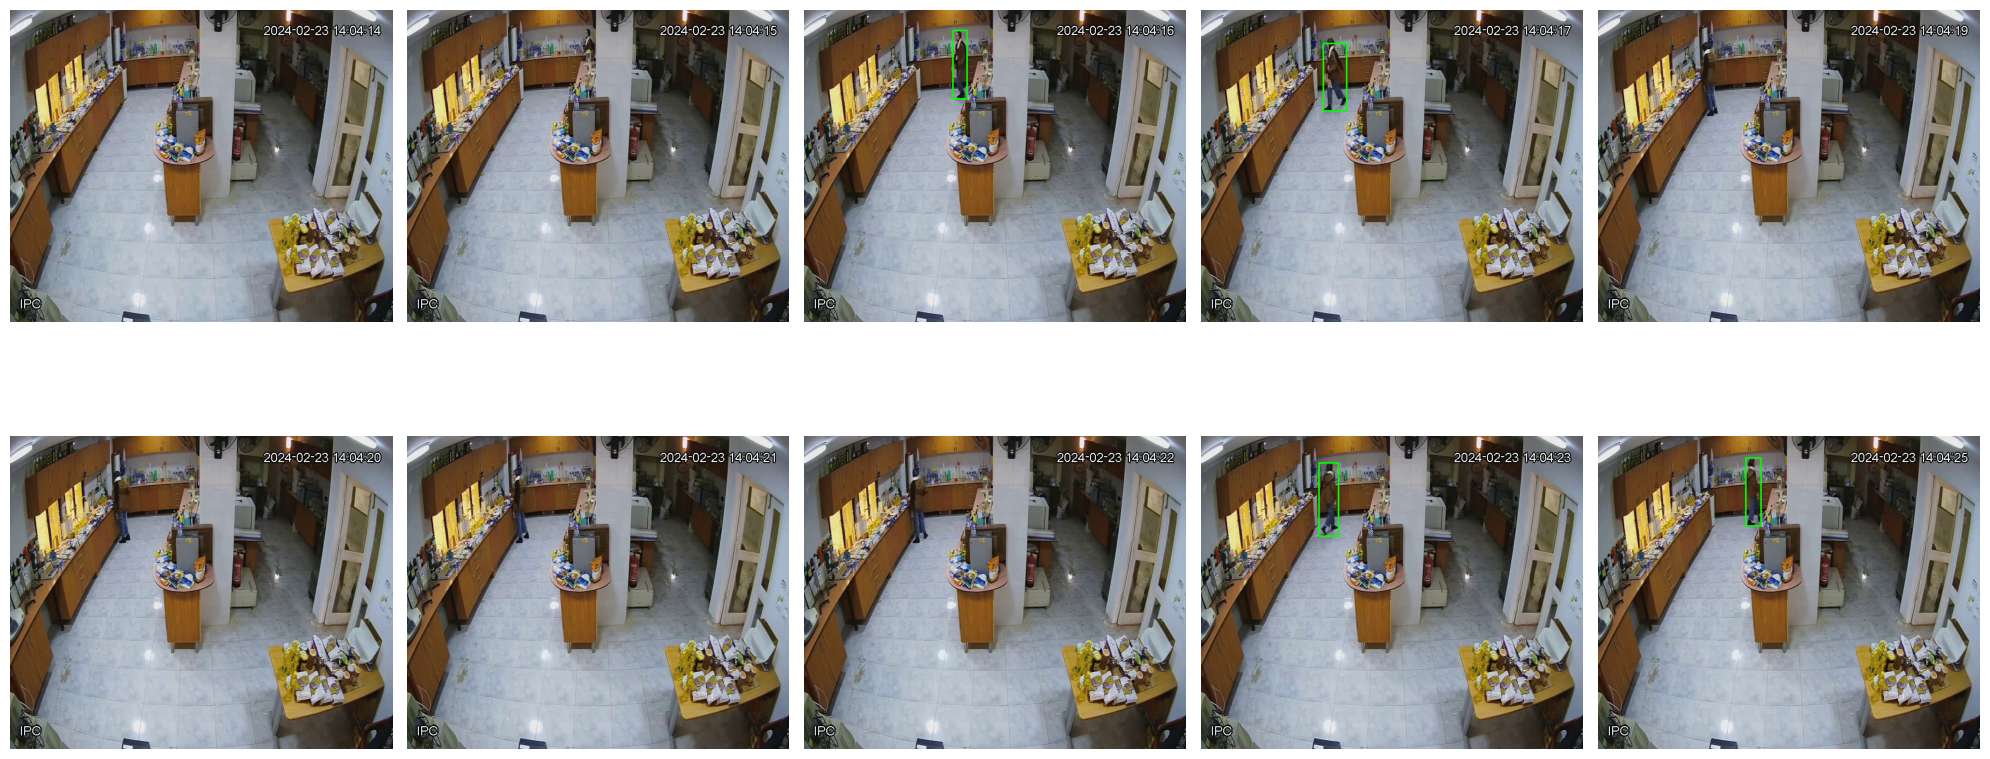

In [23]:
visualize_frames()